# Восстановление золота из руды

**Заказчик:** компания «Цифры», разрабатывающая решения для эффективной работы промышленных предприятий

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Предоставлены данные с параметрами добычи и очистки

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками

**Наименование признаков**

*[этап].[тип_параметра].[название_параметра]*

Пример: rougher.input.feed_ag

*Возможные значения для блока [этап]:*
* rougher — флотация
* primary_cleaner — первичная очистка
* secondary_cleaner — вторичная очистка
* final — финальные характеристики

*Возможные значения для блока [тип_параметра]:*
* input — сырьё
* output — продукт
* state — параметры, характеризующие текущее состояние этапа
* calculation — расчётные характеристики


## Подготовка данных

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display_html
from sklearn.dummy import DummyRegressor

from collections import namedtuple
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score


pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  

In [ ]:
train_df = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_train_new.csv')
test_df = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_test_new.csv')
full_df = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_full_new.csv')

In [ ]:
# функция для получения основной информации о DF
def inshort (df):
    rows_count, columns_count = df.shape
    print('Количество стобцов:', columns_count)
    print('Количество строк:', rows_count)
    display(df.head(5).T)
    display(df.describe().T)
    df.info()

In [ ]:
inshort(train_df)

Количество стобцов: 87
Количество строк: 14149


,0,1,2,3,4
date,2016-01-15 00:00:00,2016-01-15 01:00:00,2016-01-15 02:00:00,2016-01-15 03:00:00,2016-01-15 04:00:00
final.output.concentrate_ag,6.055403,6.029369,6.055926,6.047977,6.148599
final.output.concentrate_pb,9.889648,9.968944,10.213995,9.977019,10.142511
final.output.concentrate_sol,5.507324,5.257781,5.383759,4.858634,4.939416
final.output.concentrate_au,42.19202,42.701629,42.657501,42.689819,42.774141
...,...,...,...,...,...
secondary_cleaner.state.floatbank5_a_level,-498.310211,-500.169983,-500.129135,-499.20164,-501.686727
secondary_cleaner.state.floatbank5_b_air,8.079666,7.984757,8.013877,7.977324,7.894242
secondary_cleaner.state.floatbank5_b_level,-500.470978,-500.582168,-500.517572,-500.255908,-500.356035
secondary_cleaner.state.floatbank6_a_air,14.151341,13.998353,14.028663,14.005551,13.996647


,count,mean,std,min,25%,50%,75%,max
final.output.concentrate_ag,14148.0,5.142034,1.369586,0.000000,4.211620,4.994652,5.859540,16.001945
final.output.concentrate_pb,14148.0,10.132960,1.654930,0.000000,9.297355,10.297144,11.170603,17.031899
final.output.concentrate_sol,13938.0,9.202849,2.790516,0.000000,7.484645,8.845462,10.487508,18.124851
final.output.concentrate_au,14149.0,44.003792,4.905261,0.000000,43.276111,44.872436,46.166425,52.756638
final.output.recovery,14149.0,66.518832,10.295402,0.000000,62.545817,67.432775,72.346428,100.000000
...,...,...,...,...,...,...,...,...
secondary_cleaner.state.floatbank5_a_level,14148.0,-483.956022,37.892788,-797.142475,-500.363177,-499.702452,-487.712108,-275.073125
secondary_cleaner.state.floatbank5_b_air,14148.0,13.064590,5.765617,0.646208,8.994405,11.997547,17.982903,27.926001
secondary_cleaner.state.floatbank5_b_level,14148.0,-483.966564,39.207913,-800.006180,-500.105994,-499.914556,-453.186936,-157.396071
secondary_cleaner.state.floatbank6_a_air,14147.0,19.577539,5.764417,0.195324,14.989304,19.984175,24.991623,32.188906


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [ ]:
inshort(test_df)

Количество стобцов: 53
Количество строк: 5290


,0,1,2,3,4
date,2016-09-01 00:59:59,2016-09-01 01:59:59,2016-09-01 02:59:59,2016-09-01 03:59:59,2016-09-01 04:59:59
primary_cleaner.input.sulfate,210.800909,215.392455,215.259946,215.336236,199.099327
primary_cleaner.input.depressant,14.993118,14.987471,12.884934,12.006805,10.68253
primary_cleaner.input.feed_size,8.08,8.08,7.786667,7.64,7.53
primary_cleaner.input.xanthate,1.005021,0.990469,0.996043,0.863514,0.805575
primary_cleaner.state.floatbank8_a_air,1398.981301,1398.777912,1398.493666,1399.618111,1401.268123
primary_cleaner.state.floatbank8_a_level,-500.225577,-500.057435,-500.86836,-498.863574,-500.808305
primary_cleaner.state.floatbank8_b_air,1399.144926,1398.055362,1398.860436,1397.44012,1398.128818
primary_cleaner.state.floatbank8_b_level,-499.919735,-499.778182,-499.764529,-499.211024,-499.504543
primary_cleaner.state.floatbank8_c_air,1400.102998,1396.151033,1398.075709,1400.129303,1402.172226


,count,mean,std,min,25%,50%,75%,max
primary_cleaner.input.sulfate,5286.0,174.839652,43.027080,2.566156e+00,147.121401,177.828489,208.125438,265.983123
primary_cleaner.input.depressant,5285.0,8.683596,3.072050,3.839482e-03,6.489555,8.052207,10.027764,40.000000
primary_cleaner.input.feed_size,5290.0,7.266339,0.610219,5.650000e+00,6.890000,7.250000,7.600000,15.500000
primary_cleaner.input.xanthate,5286.0,1.383803,0.643474,4.983673e-03,0.907623,1.197610,1.797819,4.102454
primary_cleaner.state.floatbank8_a_air,5290.0,1539.494325,116.797884,5.445860e-32,1498.935802,1585.129123,1602.076529,2103.103580
primary_cleaner.state.floatbank8_a_level,5290.0,-497.665883,19.952431,-7.953163e+02,-500.357298,-499.969164,-499.568951,-57.195404
primary_cleaner.state.floatbank8_b_air,5290.0,1545.174232,122.224588,6.647490e-32,1498.970993,1595.621798,1602.323545,1813.083671
primary_cleaner.state.floatbank8_b_level,5290.0,-500.273098,32.968307,-7.999970e+02,-500.703002,-500.028514,-499.293257,-142.527229
primary_cleaner.state.floatbank8_c_air,5290.0,1527.272362,122.538034,4.033736e-32,1473.229862,1549.594682,1601.143775,1715.053773
primary_cleaner.state.floatbank8_c_level,5290.0,-498.330680,21.964876,-7.999606e+02,-501.018117,-500.017711,-498.994130,-150.937035


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [ ]:
inshort(full_df)

Количество стобцов: 87
Количество строк: 19439


,0,1,2,3,4
date,2016-01-15 00:00:00,2016-01-15 01:00:00,2016-01-15 02:00:00,2016-01-15 03:00:00,2016-01-15 04:00:00
final.output.concentrate_ag,6.055403,6.029369,6.055926,6.047977,6.148599
final.output.concentrate_pb,9.889648,9.968944,10.213995,9.977019,10.142511
final.output.concentrate_sol,5.507324,5.257781,5.383759,4.858634,4.939416
final.output.concentrate_au,42.19202,42.701629,42.657501,42.689819,42.774141
...,...,...,...,...,...
secondary_cleaner.state.floatbank5_a_level,-498.310211,-500.169983,-500.129135,-499.20164,-501.686727
secondary_cleaner.state.floatbank5_b_air,8.079666,7.984757,8.013877,7.977324,7.894242
secondary_cleaner.state.floatbank5_b_level,-500.470978,-500.582168,-500.517572,-500.255908,-500.356035
secondary_cleaner.state.floatbank6_a_air,14.151341,13.998353,14.028663,14.005551,13.996647


,count,mean,std,min,25%,50%,75%,max
final.output.concentrate_ag,19438.0,5.168470,1.372348,0.000000,4.251240,5.066094,5.895527,16.001945
final.output.concentrate_pb,19438.0,9.978895,1.669240,0.000000,9.137262,10.102433,11.035769,17.031899
final.output.concentrate_sol,19228.0,9.501224,2.787537,0.000000,7.722820,9.218961,10.947813,19.615720
final.output.concentrate_au,19439.0,44.076513,5.129784,0.000000,43.402215,45.011244,46.275313,52.756638
final.output.recovery,19439.0,67.050208,10.125840,0.000000,63.299712,68.172738,72.686642,100.000000
...,...,...,...,...,...,...,...,...
secondary_cleaner.state.floatbank5_a_level,19438.0,-488.684065,34.533396,-797.323986,-500.458467,-499.802605,-498.384187,-244.483566
secondary_cleaner.state.floatbank5_b_air,19438.0,12.198224,5.333024,0.528083,8.971105,11.019433,14.019088,27.926001
secondary_cleaner.state.floatbank5_b_level,19438.0,-487.149827,38.347312,-800.220337,-500.129462,-499.935317,-499.436708,-137.740004
secondary_cleaner.state.floatbank6_a_air,19437.0,18.959024,5.550498,-0.079426,14.983037,19.960541,24.003170,32.188906


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


Представлены 3 выборки - обучающая, тестовая и полная (обучающая+тестовая)

В обучающй выборке больше столбцов с признаками (87) и строк с данными для обучения (14149), в тестовой признаков меньше (53), как и строк со значениями (5290). Далее будет описано почему в тестовой меньше признаков. 

Признаки описывают различные показатели концентрации элементов на разных стадиях обработки, а так же размеры гранул

In [ ]:
# изменяем формат даты
train_df['date'] = pd.to_datetime(train_df['date'], format="%Y-%m-%d %H:%M:%S")
test_df['date'] = pd.to_datetime(test_df['date'], format="%Y-%m-%d %H:%M:%S")
full_df['date'] = pd.to_datetime(full_df['date'], format="%Y-%m-%d %H:%M:%S")

In [ ]:
# поиск дублей
print("Дубли в train_df:",train_df.duplicated().sum())
print("Дубли в test_df:", test_df.duplicated().sum())
print("Дубли в full_df:",full_df.duplicated().sum())

Дубли в train_df: 0
Дубли в test_df: 0
Дубли в full_df: 0


### Проверка, что эффективность обогащения рассчитана правильно. Вычисление её на обучающей выборке для признака rougher.output.recovery. Рассчет MAE между расчётами и значением признака


**RECOVERY = (C * (F-T)) / (F * (C-T))**

* C — доля золота в концентрате после флотации/очистки (rougher.output.concentrate_au)
* F — доля золота в сырье/концентрате до флотации/очистки (rougher.input.feed_au)
* T — доля золота в отвальных хвостах после флотации/очистки (rougher.output.tail_au)

In [ ]:
def calculate_recovery(rougher_output, rougher_input, rougher_tail):
    recovery = (rougher_output * (rougher_input - rougher_tail)) /\
        (rougher_input * (rougher_output - rougher_tail)) * 100
    return recovery

In [ ]:
# применение функции по рассчету recovery
recovery = calculate_recovery(train_df['rougher.output.concentrate_au'], train_df['rougher.input.feed_au'], 
                                            train_df['rougher.output.tail_au'])
print(recovery.describe())

count    14149.000000
mean        82.704502
std         14.479156
min         -0.000000
25%         79.993067
50%         85.299462
75%         90.165021
max        100.000000
dtype: float64


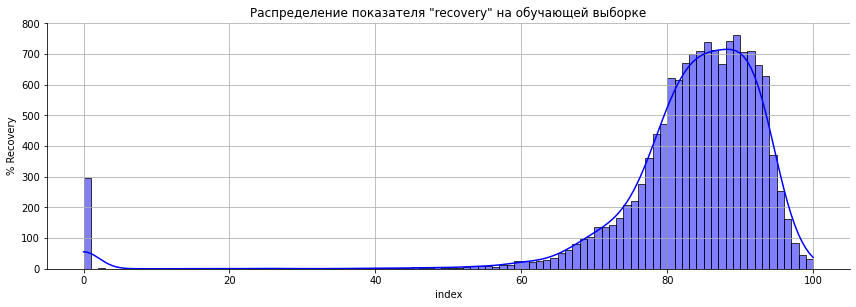

In [ ]:
sns.displot(recovery, kde=True, kind='hist',color = 'blue',bins=100, height=4, aspect=3);
plt.grid(True)
plt.xlabel('index')
plt.ylabel('% Recovery')
plt.title('Распределение показателя "recovery" на обучающей выборке');

**Вывод:**

На графике наблюдается нормальное распределение в диапазоне от 70 до 100%, а так же заметен некий выброс около 0%

In [ ]:
mae_recovery = mean_absolute_error(train_df['rougher.output.recovery'], recovery)
print('MAE =', mae_recovery.round(15))

MAE = 1e-14


**Вывод:** 

Значение *recovery* на обучающей выборке в основном выше 70%

*MAE (средняя абсолютная ошибка)* между рассчитаной по формуле эффективностью обогащения и признаком из датасета довольно низкая, а значит значение эффективности в датасете верное. В среднем значение отклоняется на 1e-14

### Анализ признаков, недоступных в тестовой выборке

In [ ]:
train_cols = train_df.columns
test_cols = test_df.columns
full_cols = full_df.columns 

# названия отличающихся столбцов
train_not_test = train_cols.difference(test_cols)\
                           .to_frame(index=False, name ='Названия отличающихся столбцов между train_df и test_df')

display (train_not_test)

train_not_full = train_cols.difference(full_cols)\
                           .to_frame(index=False, name ='Названия отличающихся столбцов между train_df и full_df')
display (train_not_full)

,Названия отличающихся столбцов между train_df и test_df
0,final.output.concentrate_ag
1,final.output.concentrate_au
2,final.output.concentrate_pb
3,final.output.concentrate_sol
4,final.output.recovery
5,final.output.tail_ag
6,final.output.tail_au
7,final.output.tail_pb
8,final.output.tail_sol
9,primary_cleaner.output.concentrate_ag


,Названия отличающихся столбцов между train_df и full_df


**Вывод:**
* тип данных в столбцах **float** (было выявлено ранее)

 Признаки недоступные в тестовой выборке:
 
* Признаки **output** - признаки продукта, т.е. целевые и поэтому отсутствуют в тестовой выборке (из них **rougher.output.recovery** и **final.output.recovery** - это суперцелевые признаки)

* Признаки **rougher.calculation** - это расчетные характеристики и отсутвуют они по причине того, что расчитываются после завершения процесса.
* Можно обратить внимание, что в основном 16 из 34 названий - содержат информацию об отвальных хвостах

### Предобработка данных

In [ ]:
# функция для отображения нескольких df рядом

def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2 style="text-align: center;">{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [ ]:
# функция для определения процента пропусков в столбцах
def percent_of_null(df):
    return (df.isnull().sum().sort_values(ascending=False) / df.shape[0] * 100).round(2).to_frame()

In [ ]:
train_null = percent_of_null(train_df)
test_null = percent_of_null(test_df)
full_null = percent_of_null(full_df)

display_side_by_side (train_null, full_null, test_null, titles = ['% пропусков в Train_df','% пропусков в Full_df', '% пропусков в Test_df'] )

,0
secondary_cleaner.output.tail_sol,11.34
rougher.state.floatbank10_e_air,3.08
rougher.input.floatbank11_xanthate,3.02
primary_cleaner.output.concentrate_sol,2.02
secondary_cleaner.state.floatbank2_a_air,1.53
final.output.concentrate_sol,1.49
rougher.input.feed_size,1.02
primary_cleaner.input.xanthate,0.71
rougher.input.feed_pb,0.71
final.output.tail_pb,0.71


In [ ]:
# присоедение к тестовой выборке целевых признаков для удобства
print("Размер выборки до присоединения -", test_df.shape)
test_df = test_df.merge(full_df[['rougher.output.recovery', 'final.output.recovery','date']], on='date', how='left')
print("Размер выборки после присоединения -", test_df.shape)

Размер выборки до присоединения - (5290, 53)
Размер выборки после присоединения - (5290, 55)


Так как данные индексируются датой и временем получения информации и соседние по времени параметры часто похожи - можно заполнить пропуски в остальных параметрах соседними значениями

In [ ]:
train_df_prepared = train_df.fillna(method='ffill')
test_df_prepared = test_df.fillna(method='ffill')


display(train_df_prepared.isna().sum().sort_values(ascending=False).to_frame(name = 'Количество пропусков в train_df_prepared').head(5))
display(test_df_prepared.isna().sum().sort_values(ascending=False).to_frame(name = 'Количество пропусков в test_df_prepared').head(5))

,Количество пропусков в train_df_prepared
date,0
rougher.state.floatbank10_b_air,0
rougher.state.floatbank10_f_air,0
rougher.state.floatbank10_e_level,0
rougher.state.floatbank10_e_air,0


,Количество пропусков в test_df_prepared
date,0
secondary_cleaner.state.floatbank3_b_air,0
rougher.state.floatbank10_d_level,0
rougher.state.floatbank10_e_air,0
rougher.state.floatbank10_e_level,0


Пропуски обработаны

**Вывод по блоку подготовка данных:**

* Была проверена верность расчета показателя эффективность обогащения
* Выявлены показатели, отличающие тестовую выборку от обучающей, предложены возможные причины их появления
* Также были заполены пропуски в данных

## Анализ данных

### Анализ изменения концентрации металлов (Au, Ag, Pb) на различных этапах очистки

In [ ]:
METALS = ['au', 'ag', 'pb']
METRICS = ['rougher.input.feed','rougher.output.concentrate' , 'primary_cleaner.output.concentrate', 'final.output.concentrate']
# основные параметры концентрации металов собраны в список METRICS из условия, кроме secondary_cleaner, так как отсутствует информация

In [ ]:
# взгляд на параметры данные по золоту
full_df.filter(like='au').head().T

,0,1,2,3,4
final.output.concentrate_au,42.192020,42.701629,42.657501,42.689819,42.774141
final.output.tail_au,2.143149,2.224930,2.257889,2.146849,2.055292
primary_cleaner.output.concentrate_au,34.174427,34.118526,33.969464,28.260743,33.044932
primary_cleaner.output.tail_au,2.106679,2.353017,2.416800,2.262051,2.277073
rougher.calculation.sulfate_to_au_concentrate,41885.707031,42050.861809,42018.101184,42029.447991,42125.354245
rougher.calculation.floatbank10_sulfate_to_au_feed,3481.779053,3498.370979,3495.348910,3498.578313,3494.800771
rougher.calculation.floatbank11_sulfate_to_au_feed,3520.337158,3489.981857,3502.359819,3499.162912,3506.679315
rougher.calculation.au_pb_ratio,2.838687,2.858998,2.945989,3.002340,3.169615
rougher.input.feed_au,6.486150,6.478583,6.362222,6.118189,5.663707
rougher.output.concentrate_au,19.793808,20.050975,19.737170,19.320810,19.216101


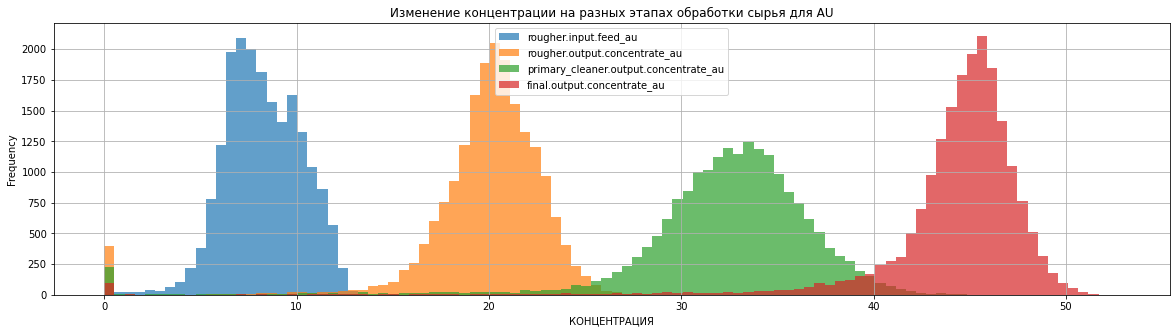

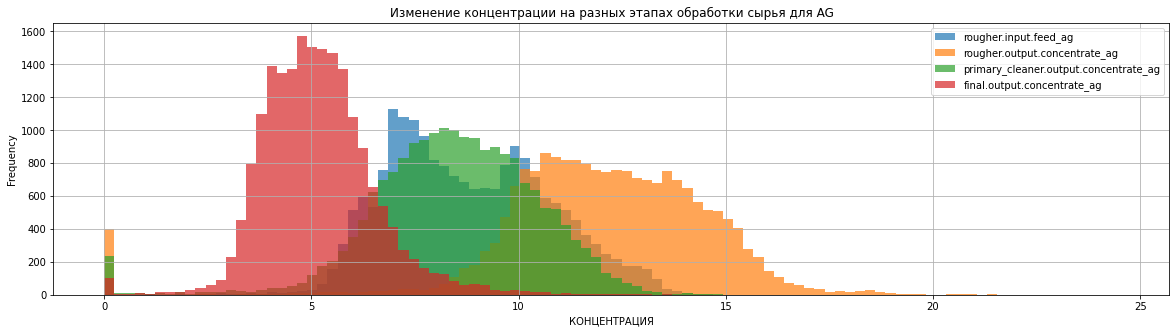

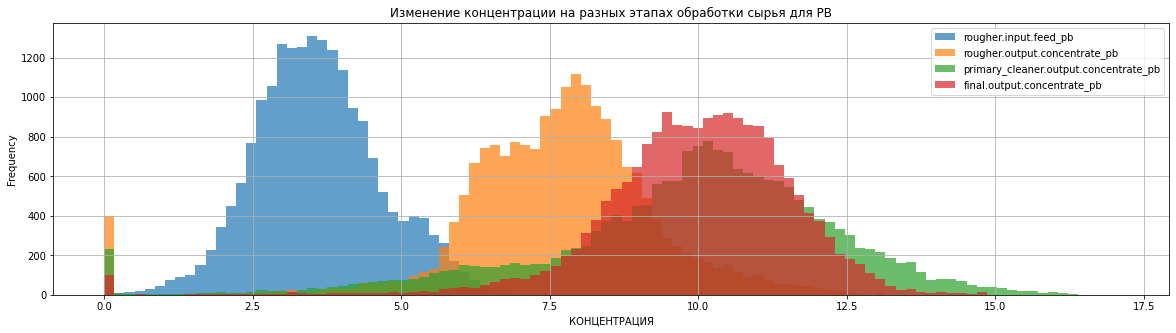

In [ ]:
for metal in METALS:
    names_for_metrics = ['{}_{}'.format(x, metal) for x in METRICS]
    
    full_df[names_for_metrics].plot(
                          title = 'Изменение концентрации на разных этапах обработки сырья для {}'.format(metal.upper()),
                           kind = 'hist',
                           bins = 100,
                           grid = True,
                         legend = True,
                        figsize = (20,5),
                          alpha = 0.7).set(xlabel = 'КОНЦЕНТРАЦИЯ')
    plt.show()

**Выводы:**

* У золота наименьшая концентрация у сырья перед флотацией, далее после флотации, после первой очистки и максимальная в финальном продукте. Границы этапов очень четкие
* У серебра наименьшая концентрация на финальном этапе (это логично, так как наш целевой продукт золото и значения должны быть обратнопрапорциональными), далее идет концентрация после первой очистки и в сырье, наибольшая концентрация после флотации сырья
* У олова наименьшая концентрация на этапе сырья, далее после флотации и максимальные значения концентрации достигаются после первичной очистки и в готовом продукте (что схоже с концентрацией золота, однако гораницы не такие четкие)

Также обратим внимание на выбросы в виде нулевых значений.



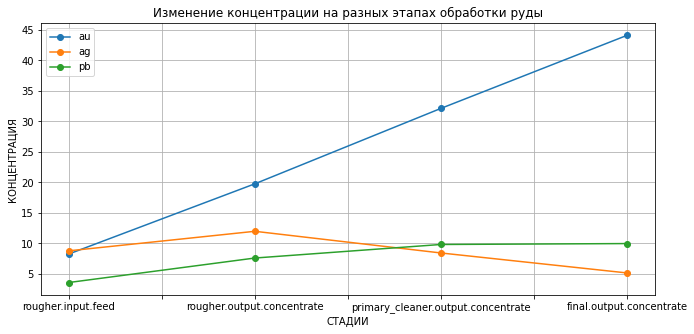

,rougher.input.feed,rougher.output.concentrate,primary_cleaner.output.concentrate,final.output.concentrate
au,8.27,19.77,32.12,44.08
ag,8.79,11.99,8.44,5.17
pb,3.6,7.61,9.83,9.98


In [ ]:
# найдем средние значения на разных этапах
metals_concentrate = pd.DataFrame(columns = METRICS)

for metal in METALS:
         
    for metric in METRICS:
        metals_concentrate.loc[metal, metric] = full_df ['{}_{}'.format(metric, metal)].mean().round(2)

for metal in METALS:
    metals_concentrate.loc[metal].plot(
        title='Изменение концентрации на разных этапах обработки руды', 
        grid=True, 
        legend=True,
        marker='o',
        figsize=(11, 5)
    ).set(xlabel='СТАДИИ', ylabel = 'КОНЦЕНТРАЦИЯ')
plt.show()

display(metals_concentrate)

**Вывод:**

* Концентрация *золота* в среднем увеличивается с 8 до 44% (в 5 раз) на финальной стадии
* Концентрация *серебра* наоборот снижается к концу процесса обработки руды
* Концентрация *олова* в среднем увеличивается, однако не значительно (на 6 п.п.)

### Сравнение распределения размеров гранул сырья (feed_size) на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной

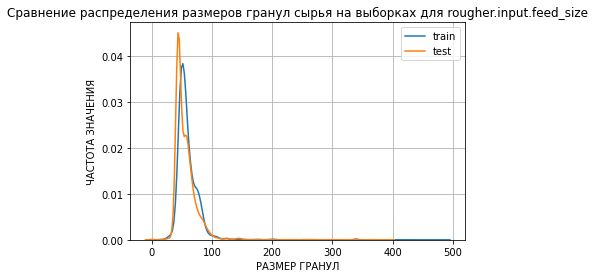

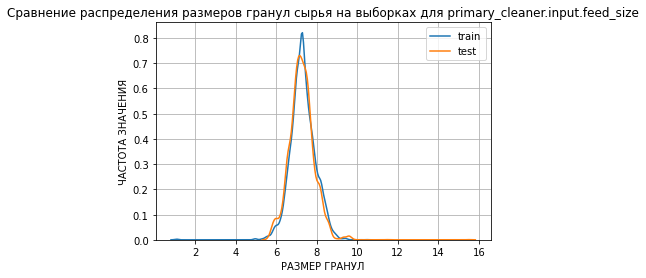

In [ ]:
for metric in ['rougher.input.feed_size', 'primary_cleaner.input.feed_size']:
    for label, df in (('train', train_df_prepared), ('test', test_df_prepared)): 
        sns.kdeplot(df[metric],alpha=0.5, label=label);
        plt.grid(True)
        plt.legend()
        plt.xlabel('РАЗМЕР ГРАНУЛ')
        plt.ylabel( 'ЧАСТОТА ЗНАЧЕНИЯ')
        plt.title('Сравнение распределения размеров гранул сырья на выборках для {}'.format(metric));
        
#         df[metric].plot(
#                 title = 'Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках для {}'.format(metric),
#                 kind='hist', 
#                 bins=100, 
#                 grid=True, 
#                 legend=True,
#                 figsize=(20, 5),
#                 alpha=0.5,
#                 label=label,
#             ).set(xlabel='РАЗМЕР ГРАНУЛ', ylabel = 'ЧАСТОТА ЗНАЧЕНИЯ')
  
    plt.show()

**Вывод:**

На графике rougher.input.feed_size размеры гранул до процесса флотации, они довольно крупные. Значения из Обучающей выборки находятся в том же диапазоне, что и в тестовой, но в большем объеме. 

Такая же ситуация наблюдается с размером гранул перед первичной очисткой.

Таким образом, оценка модели будет правильной

### Исследование суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах

In [ ]:
for metric in METRICS:
    train_df_prepared[metric] = 0
    for metal in METALS + ['sol']:
        train_df_prepared[metric] += train_df_prepared['{}_{}'.format(metric, metal)]
    
train_df_prepared[METRICS].head(5)

,rougher.input.feed,rougher.output.concentrate,primary_cleaner.output.concentrate,final.output.concentrate
0,51.680034,66.424950,72.640924,63.644396
1,50.659114,67.012710,72.543485,63.957723
2,50.609929,66.103793,72.095042,64.311180
3,51.061546,65.752751,59.957723,63.573449
4,47.859163,65.908382,71.321010,64.004667


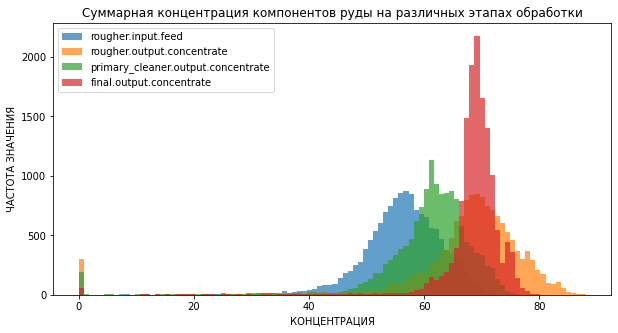

In [ ]:
train_df_prepared[METRICS].plot(kind='hist', alpha =0.7, figsize=(10,5), bins=100, title="Суммарная концентрация компонентов руды на различных этапах обработки")\
                          .set(xlabel='КОНЦЕНТРАЦИЯ', ylabel = 'ЧАСТОТА ЗНАЧЕНИЯ');

Самые многочисленные суммарные значения концентрации на финальном этапе, однако можно обратить внимание, что более высокие значения суммарной концентрации на моменте после флотации - хоть и количество этих значений не так велико

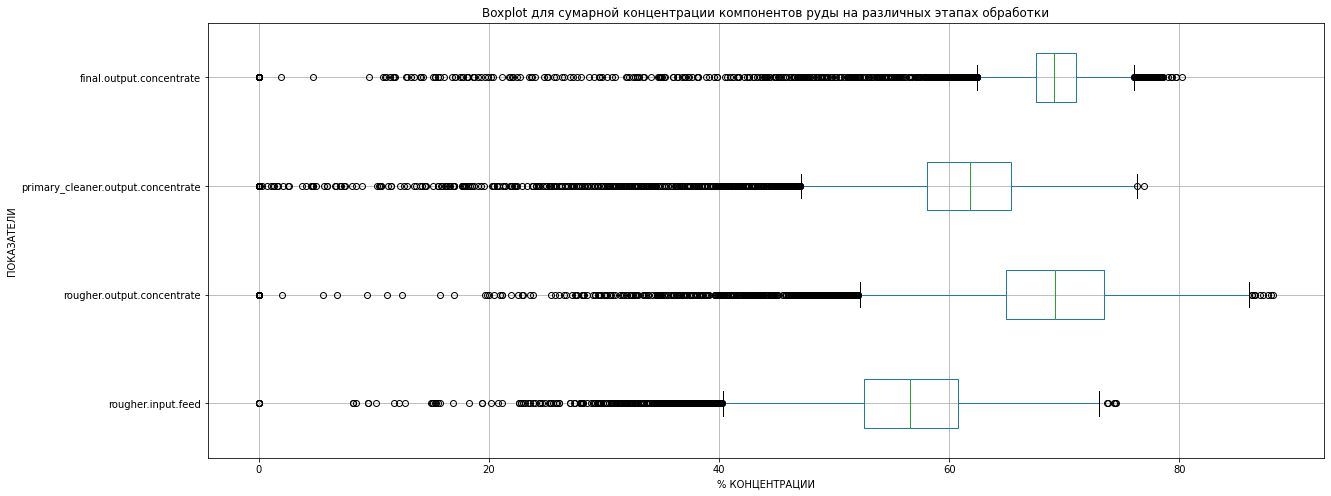

In [ ]:
# чтобы разобраться с выбросами посмотрим значения на boxplot
train_df_prepared[METRICS].boxplot(figsize = (20,8), vert=False)
plt.title('Boxplot для сумарной концентрации компонентов руды на различных этапах обработки')
plt.xlabel('% КОНЦЕНТРАЦИИ')
plt.ylabel('ПОКАЗАТЕЛИ');

In [ ]:
# поиск квантилей и показателей boxplot

def stats_func(df,x):
    q1,q2,q3,q4=df[x].quantile([0.25,0.5,0.75,1]).round(2)
    iqr = round(q3-q1,2)
    low = round(q1-iqr*1.5,2)
    high = round(q3+iqr*1.5,2)
    mean = df[x].mean().round(2)
    median = df[x].median().round(2)
    print(x)
    print('q1 =',q1,'q2 =',q2,'q3 =',q3,'q4=',q4)
    print('Межквартильный размах =', iqr)
    print('mean =', mean)
    print('median =', median)
    print('Нижняя граница', low)
    print('Верхняя граница',high)
    print()
    return iqr, low, high, mean, median

In [ ]:
list_of_results=[]
for x in METRICS:
    list_of_results.append(stats_func(train_df_prepared,x))

rougher.input.feed
q1 = 52.57 q2 = 56.63 q3 = 60.76 q4= 74.46
Межквартильный размах = 8.19
mean = 56.24
median = 56.63
Нижняя граница 40.28
Верхняя граница 73.05

rougher.output.concentrate
q1 = 64.91 q2 = 69.18 q3 = 73.43 q4= 88.14
Межквартильный размах = 8.52
mean = 67.17
median = 69.18
Нижняя граница 52.13
Верхняя граница 86.21

primary_cleaner.output.concentrate
q1 = 58.05 q2 = 61.79 q3 = 65.36 q4= 76.92
Межквартильный размах = 7.31
mean = 60.17
median = 61.79
Нижняя граница 47.08
Верхняя граница 76.33

final.output.concentrate
q1 = 67.56 q2 = 69.14 q3 = 70.97 q4= 80.21
Межквартильный размах = 3.41
mean = 68.39
median = 69.14
Нижняя граница 62.45
Верхняя граница 76.08



In [ ]:
list_of_results

[(8.19, 40.28, 73.05, 56.24, 56.63),
 (8.52, 52.13, 86.21, 67.17, 69.18),
 (7.31, 47.08, 76.33, 60.17, 61.79),
 (3.41, 62.45, 76.08, 68.39, 69.14)]

In [ ]:
print('Количество позиций до удаления выбросов из обучающей выборки:', train_df_prepared.shape[0])

Количество позиций до удаления выбросов из обучающей выборки: 14149


In [ ]:
# отбор значений выбросов и замена на NaN
train_df_clean=train_df_prepared
train_df_clean.loc[train_df_clean['rougher.input.feed'] <= (list_of_results[0][1]),'rougher.input.feed'] = np.nan
train_df_clean.loc[train_df_clean['rougher.input.feed'] >= (list_of_results[0][2]),'rougher.input.feed'] = np.nan

train_df_clean.loc[train_df_clean['rougher.output.concentrate'] <= (list_of_results[0][1]),'rougher.output.concentrate'] = np.nan
train_df_clean.loc[train_df_clean['rougher.output.concentrate']>= (list_of_results[0][2]),'rougher.output.concentrate'] = np.nan

train_df_clean.loc[train_df_clean['primary_cleaner.output.concentrate'] <= (list_of_results[0][1]),'primary_cleaner.output.concentrate'] = np.nan
train_df_clean.loc[train_df_clean['primary_cleaner.output.concentrate'] >= (list_of_results[0][2]),'primary_cleaner.output.concentrate'] = np.nan

train_df_clean.loc[train_df_clean['final.output.concentrate'] <= (list_of_results[0][1]),'final.output.concentrate'] = np.nan
train_df_clean.loc[train_df_clean['final.output.concentrate'] >= (list_of_results[0][2]),'final.output.concentrate'] = np.nan


In [ ]:
# удаление выбросов
train_df_clean = train_df_clean.dropna(subset=['rougher.input.feed','rougher.output.concentrate','primary_cleaner.output.concentrate','final.output.concentrate'],axis=0)

print('Количество позиций после удаления выбросов из обучающей выборки:', train_df_clean.shape[0])
print("Удалено", round(100-(11924*100/14149),2),"% значений из обучающей выборки")

Количество позиций после удаления выбросов из обучающей выборки: 8880
Удалено 15.73 % значений из обучающей выборки


**Вывод:**

Были исследованны суммарные значения концентрации веществ в руде - достигают максимума после флотации, однако более узкая и высокая диаграмма суммарных значений после финального этапа очистки (более централизированные суммарные значения, достигающие пика на 70%).

Так же были изучены статистические значения для построения boxplot с целью удаления выбросов, мешающих верному анализу и обучению модели

Далее хочу попробовать обучить модель на очищенных от выбросов данных(train_df_clean) и на неочищенных (train_df_prepared), чтобы узнать, где будет выше точность

## Модель

### Функция для вычисления итоговой sMAPE

эффективность обогащения чернового концентрата - **rougher.output.recovery**

эффективность обогащения финального концентрата - **final.output.recovery**

In [ ]:
# ввод функции для рассчета smape отедльно для rougher и final
def smape(y_target, y_pred):
    return ((1/len(y_target)) * np.sum(2 * np.abs(y_target - y_pred) / (np.abs(y_target) + np.abs(y_pred)))) * 100

smape_score = make_scorer(smape, greater_is_better=False)

### Обучение разных моделей и оценка их качества кросс-валидацией. Выбор лучшей модели и проверка её на тестовой выборке

In [ ]:
# приведем в соответствие количество стобцов (уберем из обучающей выборки столбцы, отсутствующие в тестовой)

print ("Количество столбцов в test_df_prepared:", test_df_prepared.shape[1])
print ("Количество столбцов в train_df_clean:", train_df_clean.shape[1])
print ("Количество столбцов в train_df_prepared:", train_df_prepared.shape[1])

train_not_test_prepared = train_df_clean.columns.difference(test_df_prepared.columns)
train_df_clean = train_df_clean.drop(train_not_test_prepared, axis = 'columns')
train_df_prepared = train_df_prepared.drop(train_not_test_prepared, axis = 'columns')

print ("Количество столбцов в train_df_clean после обработки:", train_df_clean.shape[1])
print ("Количество столбцов в train_df_prepared после обработки:", train_df_prepared.shape[1])

Количество столбцов в test_df_prepared: 55
Количество столбцов в train_df_clean: 91
Количество столбцов в train_df_prepared: 91
Количество столбцов в train_df_clean после обработки: 55
Количество столбцов в train_df_prepared после обработки: 55


**Задача регресии** - Будут использованы следующие Модели для обучения:
- Линейная регрессия
- Логистическая регрессия
- Дерево решений
- Случайный лес

In [ ]:
# определим target и feature
TARGETS = ['rougher.output.recovery', 'final.output.recovery']

# для обучающей выборки
target_train = train_df_prepared[TARGETS]
feature_train = train_df_prepared.drop(labels=TARGETS+['date'], axis ='columns')
# для данных, очищенных от выбросов
target_train_clean = train_df_clean[TARGETS]
feature_train_clean = train_df_clean.drop(labels=TARGETS+['date'], axis ='columns')

# для тестовой выборки
target_test = test_df_prepared[TARGETS]
feature_test = test_df_prepared.drop(labels=TARGETS+['date'], axis ='columns')

In [ ]:
# нормализуем признаки
scaler = preprocessing.MinMaxScaler()
# неочищенные данные
scaler.fit(feature_train)
feature_train_np = scaler.transform(feature_train)
feature_test_np = scaler.transform(feature_test)
feature_train_norm = pd.DataFrame(feature_train_np, columns= feature_train.columns)
feature_test_norm = pd.DataFrame(feature_test_np, columns=feature_test.columns)
# очищенные данные
scaler.fit(feature_train_clean)
feature_train_np_clean = scaler.transform(feature_train_clean)
feature_test_np_clean = scaler.transform(feature_test)
feature_train_norm_clean = pd.DataFrame(feature_train_np_clean, columns= feature_train.columns)
feature_test_norm_clean = pd.DataFrame(feature_test_np_clean, columns=feature_test.columns)

#### Константная модель

In [ ]:
rfm_dummy = DummyRegressor(strategy='median')

rfm_dummy.fit(feature_train_clean,target_train_clean)
rfm_pred = rfm_dummy.predict(feature_train_clean)
r,f=smape(target_train_clean, rfm_pred)
print(smape(target_train_clean, rfm_pred))
print("Итоговая smape =", 0.25*r+0.75*f)

rougher.output.recovery    6.811790
final.output.recovery      8.880492
dtype: float64
Итоговая smape = 8.363316703905763


#### Линейная регрессия

In [ ]:
# применение модели линейной регрессии
model_linear = LinearRegression() 
# на неочищенных нормализованных данных
model_linear.fit(feature_train_norm,target_train) 
predictions_linear = model_linear.predict(feature_train_norm) 
# на очищщенных нормализованных данных
model_linear.fit(feature_train_norm_clean,target_train_clean) 
predictions_linear_clean = model_linear.predict(feature_train_norm_clean) 

In [ ]:
# делим предсказания на 2 колонки (черновой и финальный конццентрат)
C = np.asarray(predictions_linear)
rougher_pred_linear, final_pred_linear = np.hsplit(C,2)
C2 = np.asarray(predictions_linear_clean)
rougher_pred_linear_clean, final_pred_linear_clean= np.hsplit(C2,2)

In [ ]:
print('rougher.output.recovery')
rougher_cvs = cross_val_score (model_linear,feature_train_norm,target_train['rougher.output.recovery'] , cv=5, scoring=smape_score)
print(rougher_cvs)
print('Среднее',(-1)*rougher_cvs.mean())
print('final.output.recovery')
final_cvs = cross_val_score (model_linear,feature_train_norm,target_train['final.output.recovery'] , cv=5, scoring=smape_score)
print(final_cvs)
print('Среднее', (-1)*final_cvs.mean())

rougher.output.recovery
[-14.97104632  -7.71742663 -17.68267912 -14.57577066  -9.06549457]
Среднее 12.80248345848199
final.output.recovery
[-14.21317347 -10.7516344  -11.1015969  -10.47709069 -14.68300613]
Среднее 12.245300320302253


**Вывод:**

Средний результат smape на линейной регрессии при применении cross_val_score равен 12.8% для rougher.output.recovery и 12.2% для final.output.recovery. Модель ошибается на 12%. Не очень хорошие результаты

#### Дерево решений

In [ ]:
%%time
# использование GridSearchCV для поиска лучших параметров rougher.output.recovery

grid_model = GridSearchCV(DecisionTreeRegressor(random_state=12345), param_grid = {'max_depth': range(1,15)}, n_jobs=-1,
                               cv=5, scoring=smape_score)
grid_model.fit(feature_train_norm_clean,target_train_clean['rougher.output.recovery'])

print("\n Наилучшие гиперпараметры для модели Дерево решений (rougher.output.recovery):\n", grid_model.best_params_)
print("\n Наилучшее значение smape для модели Дерево решений (rougher.output.recovery):\n",(-1)* grid_model.best_score_)



 Наилучшие гиперпараметры для модели Дерево решений (rougher.output.recovery):
 {'max_depth': 3}

 Наилучшее значение smape для модели Дерево решений (rougher.output.recovery):
 7.439895651017139
CPU times: user 16.1 s, sys: 55.8 ms, total: 16.2 s
Wall time: 16.2 s


In [ ]:
%%time
# использование GridSearchCV для поиска лучших параметров final.output.recovery

grid_model2 = GridSearchCV(DecisionTreeRegressor(random_state=12345), param_grid = {'max_depth': range(1,15)}, n_jobs=-1,
                               cv=5, scoring=smape_score)
grid_model2.fit(feature_train_norm_clean,target_train_clean['final.output.recovery'])

print("\n Наилучшие гиперпараметры для модели Дерево решений (final.output.recovery):\n", grid_model2.best_params_)
print("\n Наилучшее значение smape для модели Дерево решений (final.output.recovery):\n", (-1)*grid_model2.best_score_)



 Наилучшие гиперпараметры для модели Дерево решений (final.output.recovery):
 {'max_depth': 2}

 Наилучшее значение smape для модели Дерево решений (final.output.recovery):
 8.501452342402128
CPU times: user 16.8 s, sys: 41.5 ms, total: 16.8 s
Wall time: 16.9 s


**Вывод:**

Для модели дерева решений наилучшим значением **smape** является 6.9% (при тренировке на нормализированных и очищенных от выбросов данных). Это значение ниже полученного на контрастной модели (медианные значения) - 8.36%, однако на модели линейной регрессии значение меньше - 6.27%

#### Случайный лес

Подбор гиперпараметров с помощью RandomizedSearchCV для модели случайного леса (обучение на нормализованных и очищенных от выбросов данных)
* rougher
* final

In [ ]:
%%time

param_rnd = {
        'max_depth' : range(1,15),
        'n_estimators' : range(100,500,100)}
randomized_model = RandomizedSearchCV (RandomForestRegressor(random_state=12345), 
                                               param_distributions = param_rnd, 
                                               cv=5, 
                                               n_jobs=-1, 
                                               scoring=smape_score) 
randomized_model.fit(feature_train_norm_clean,target_train_clean['rougher.output.recovery'])
params_rougher = randomized_model.best_params_
params_score = randomized_model.best_score_
randomized_model_forest = RandomForestRegressor(**params_rougher, random_state = 12345)
randomized_model_forest.fit(feature_train_norm_clean,target_train_clean['rougher.output.recovery'])
print('\n Наилучшие гиперпараметры для модели случайного леса (rougher.output.recovery):\n', params_rougher)
print('\n Наилучшее значение smape для модели случайного леса (rougher.output.recovery):\n',(-1)* params_score)

In [ ]:
%%time

param_rnd = {
        'max_depth' : range(1,15),
        'n_estimators' : range(100,500,100)}
randomized_model2 = RandomizedSearchCV (RandomForestRegressor(random_state=12345), 
                                               param_distributions = param_rnd, 
                                               cv=5, 
                                               n_jobs=-1, 
                                               scoring=smape_score) 
randomized_model2.fit(feature_train_norm_clean,target_train_clean['final.output.recovery'])
params_final = randomized_model2.best_params_
params_score2= randomized_model2.best_score_
randomized_model2_forest = RandomForestRegressor(**params_final, random_state = 12345)
randomized_model2_forest.fit(feature_train_norm_clean,target_train_clean['final.output.recovery'])
print('\n Наилучшие гиперпараметры для модели случайного леса (final.output.recovery):\n', params_final)
print('\n Наилучшее значение smape для модели случайного леса (rougher.output.recovery):\n', (-1)*params_score2)

Предсказание целевых значений, с помощью моделей с выбранными гиперпараметрами 
* на нормализированных и очищенных данных
* на нормализированных и неочищенных данных
* на ненормализованных и неочищенных данных

In [ ]:
print('rougher.output.recovery')
rougher_cvs_forest = cross_val_score (randomized_model_forest,feature_train_norm_clean,target_train_clean['rougher.output.recovery'] , cv=5, scoring=smape_score)
print(rougher_cvs_forest)
print('Среднее',(-1)* rougher_cvs_forest.mean())

print('final.output.recovery')
final_cvs_forest = cross_val_score (randomized_model_forest,feature_train_norm_clean,target_train_clean['final.output.recovery'] , cv=5, scoring=smape_score)
print(final_cvs_forest)
print('Среднее', (-1)*final_cvs_forest.mean()

**Вывод:**

Наилучшее значение sMAPE на обучающей выборке - при применении модели случайного леса = 6.05%, тоесть модель ошибается на 6.05%.
На 2 месте модель линейной регрессии = 6.27%. Также стоит обратить внимание, что показатель точности для модели случайного леса выше. 

Показатель sMAPE на контрастной выборке = 8.36%, это немного хуже, чем на модели случяайного леса.

### Применение модели на тестовой выборке

In [ ]:
rougher_prediction_forest_test = randomized_model_forest.predict(feature_test_norm_clean)

final_prediction_forest_test = randomized_model2_forest.predict(feature_test_norm_clean)

print('sMAPE на очищенных нормированных данных на тестовой выборке')
rougher_smape_test = smape ( target_test['rougher.output.recovery'], rougher_prediction_forest_test)
final_smape_test = smape ( target_test['final.output.recovery'], final_prediction_forest_test)
print('rougher_smape', rougher_smape_test)
print('final_smape', final_smape_test)
print('Итоговый smape',0.25*rougher_smape_test+0.75*final_smape_test,'\n')

## Вывод

Таким образом, наилучшим показателем sMAPE на тестовой выборке является - 8.78% (модель случайного леса с гиперпараметрами, подобранными RandomizedSearchCV на нормализованных очищенных данных)